In [50]:
import os
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import matplotlib as mpl
import math
import matplotlib.ticker as ticker

from cartopy.feature import NaturalEarthFeature

In [10]:
#fname = os.getcwd() + '/home/prabu/Research/GOES_16_data/OR_ABI-L2-AODC-M6_G16_s20211400101152_e20211400103525_c20211400105138.nc'
file_id = Dataset("/home/prabu/Research/GOES_16_data/OR_ABI-L2-AODC-M6_G16_s20211400101152_e20211400103525_c20211400105138.nc")

In [53]:
print(file_id.variables['AOD'])
print(file_id.variables['AOD'][:,:])
print('AOD range is', (file_id.variables['AOD'].valid_range)*(file_id.variables['AOD'].scale_factor)+(file_id.variables['AOD'].add_offset))

<class 'netCDF4._netCDF4.Variable'>
uint16 AOD(y, x)
    _FillValue: 65535
    long_name: ABI L2+ Aerosol Optical Depth at 550 nm
    standard_name: atmosphere_extinction_optical_thickness_due_to_ambient_aerosol
    valid_range: [    0 65530]
    scale_factor: 7.706e-05
    add_offset: -0.05
    units: 1
    resolution: y: 0.000056 rad x: 0.000056 rad
    coordinates: sunglint_angle retrieval_local_zenith_angle quantitative_local_zenith_angle retrieval_solar_zenith_angle quantitative_solar_zenith_angle aod_product_wavelength t y x
    grid_mapping: goes_imager_projection
    cell_methods: sunglint_angle: point (no pixel produced over sea only) retrieval_local_zenith_angle: point (good or degraded quality pixel produced) quantitative_local_zenith_angle: point (good quality pixel produced) retrieval_solar_zenith_angle: point (good or degraded quality pixel produced) quantitative_solar_zenith_angle: point (good quality pixel produced) t: point area: point
    ancillary_variables: DQF
unli

In [74]:
aa = file_id.variables['AOD'][:,:]
len(aa)
len(aa[1])
np.max(aa[2])
indices = np.where(aa == aa.max())
print(indices)

aa[1][1]

(array([1449]), array([478]))


masked

In [14]:
print((file_id.__getattr__('title')),'spatial resolution is', (file_id.__getattr__('spatial_resolution')))

ABI L2 Aerosol Optical Depth spatial resolution is 2km at nadir


In [15]:
print('AOD unit is', (file_id.variables['AOD'].__getattr__('units')))

AOD unit is 1


In [77]:
def Degrees(file_id):
    proj_info = file_id.variables['goes_imager_projection']
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis
    
    #Data info
    lat_rad_1d = file_id.variables['x'][:]
    lon_rad_1d = file_id.variables['y'][:]
    
    #Create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)
    
    #lat/lon calculus routine from satellite radian angle vectors
    lambda_0 = (lon_origin*np.pi)/180.0
    
    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)
    +(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)
    
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    
    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)
    
    Lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    Lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    return Lat, Lon

In [78]:
proj_info

NameError: name 'proj_info' is not defined

In [19]:
def AOD_Data(file_id):
    #Read in AOD data
    AOD_data = file_id.variables['AOD'][:,:]

    #Select quality of AOD data pixels using the "DQF" variable
    #High quality: DQF = 0, Medium quality: DQF = 1, Low quality: DQF = 2, not retrieved (NR): DQF = 3
    #Science team recommends using High and Medium qualities for operational applications- 
    #(e.g.,mask low quality and NR pixels)
    DQF = file_id.variables['DQF'][:,:]
    Quality_Mask = (DQF > 1)
    AOD = np.ma.masked_where(Quality_Mask, AOD_data)
    return AOD

In [22]:
AOD = AOD_Data(file_id)
Lat, Lon = Degrees(file_id)

print('AOD: minimum value is ' + str(np.min(AOD)) + ';' + ' maximum value is ' + str(np.max(AOD)))
print('Latitude: minimum value is ' + str(np.min(Lat)) + ' degrees;' + ' maximum value is ' 
+ str(np.max(Lat)) + ' degrees')
print('Longitude: minimum value is ' + str(np.min(Lon)) + ' degrees;' + ' maximum value is ' 
+ str(np.max(Lon)) + ' degrees')

/tmp/ipykernel_4518/871626759.py:23: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
/tmp/ipykernel_4518/871626759.py:29: RuntimeWarning: invalid value encountered in sqrt
  Lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))


AOD: minimum value is -0.04969176; maximum value is 0.19674613
Latitude: minimum value is 14.57134 degrees; maximum value is 56.635967 degrees
Longitude: minimum value is -152.05498 degrees; maximum value is -52.947044 degrees


In [23]:

def AOD_Data_Settings():
    #Create custom continuous colormap for AOD data
    #.set_over sets color for plotting data > max
    color_map = mpl.colors.LinearSegmentedColormap.from_list('custom_AOD', [(0, 'indigo'),(0.1, 'mediumblue'), 
    (0.2, 'blue'), (0.3, 'royalblue'), (0.4, 'skyblue'), (0.5, 'cyan'), (0.6, 'yellow'), (0.7, 'orange'), 
    (0.8, 'darkorange'), (0.9, 'red'), (1, 'firebrick')], N = 150)
    color_map.set_over('darkred')
    
    #Set range for plotting AOD data (data min, data max, contour interval) (MODIFY contour interval)
    #interval: 0.1 = runs faster/coarser resolution, 0.01 = runs slower/higher resolution
    data_range = np.arange(0, 1.1, 0.05)
    
    return color_map, data_range

In [24]:
def AOD_Colorbar():
    last_axes = plt.gca()
    cbar_ax = fig.add_axes([0, 0, 0, 0])
    plt.draw()
    posn = ax.get_position()
    cbar_ax.set_position([0.35, posn.y0 - 0.07, 0.3, 0.02])
    color_map = mpl.colors.LinearSegmentedColormap.from_list('custom_AOD', [(0, 'indigo'),(0.1, 'mediumblue'), 
    (0.2, 'blue'), (0.3, 'royalblue'), (0.4, 'skyblue'), (0.5, 'cyan'), (0.6, 'yellow'), (0.7, 'orange'), 
    (0.8, 'darkorange'), (0.9, 'red'), (1, 'firebrick')], N = 150)
    color_map.set_over('darkred')
    norm = mpl.colors.Normalize(vmin = 0, vmax = 1)
    cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap = color_map, norm = norm, orientation = 'horizontal', 
    ticks = [0, 0.25, 0.5, 0.75, 1], extend = 'max')
    cb.set_label(label = 'AOD', size = 'medium', weight = 'bold')
    cb.ax.set_xticklabels(['0', '0.25', '0.50', '0.75', '1.0'])
    cb.ax.tick_params(labelsize = 'medium')
    plt.sca(last_axes)

In [29]:
def ABI_Map_Settings_PC(ax):
    #Set up and label the lat/lon grid
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks([-160, -140, -120, -100, -80, -60, -40, -20], crs = ccrs.PlateCarree())
    ax.set_yticks([-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80], crs = ccrs.PlateCarree())
    ax.tick_params(length = 0)
    ax.grid(linewidth = 0.5, zorder = 3)
    ax.coastlines(resolution = '50m', zorder = 3)
    ax.add_feature(cfeature.BORDERS, zorder = 3)
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'cultural', name = 'admin_1_states_provinces', 
    scale = '50m'), facecolor = 'none', lw = 0.5, edgecolor = 'black', zorder = 2)
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'ocean', scale = '50m'), 
    facecolor = 'lightgrey')
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'land', scale = '50m'), 
    facecolor = 'grey')
    ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'lakes', scale = '50m'), 
    facecolor = 'lightgrey', edgecolor = 'black', zorder = 2)
    ax.set_extent([-135, -65, 15, 55], crs = ccrs.PlateCarree())

/tmp/ipykernel_4518/871626759.py:23: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
/tmp/ipykernel_4518/871626759.py:29: RuntimeWarning: invalid value encountered in sqrt
  Lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))


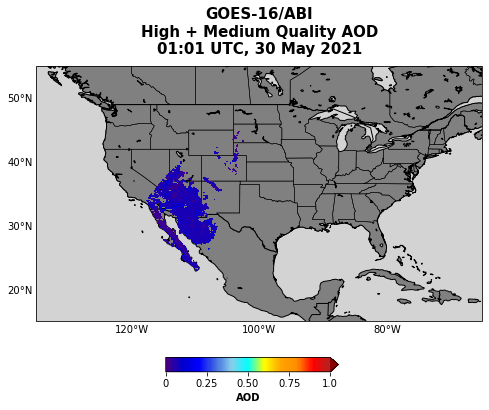

In [41]:
AOD = AOD_Data(file_id)

#Read in latitutude and longitude values in degrees
Lat, Lon = Degrees(file_id)

#Set up figure and map projection: PlateCarree(central_longitude)
#Plate Carree: equidistant cylindrical projection w/equator as the standard parallel;- 
#default central_longitude = 0
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())

#Format map with Plate Carree projection
ABI_Map_Settings_PC(ax)

#Add and format title
#Reverse indexing (from right to left) of file name automatically adds satellite, time, and year to title
plt.title('GOES-' + fname[-53:-51] + '/ABI\nHigh + Medium Quality AOD\n' + fname[-42:-40] + ':' + fname[-40:-38]
 + ' UTC, 30 May ' +fname[-49:-45], y = 1.025, ma = 'center', size = 15, weight = 'bold')

#Add AOD colorbar
AOD_Colorbar()

#Plotting settings for AOD data
color_map, data_range = AOD_Data_Settings()

if AOD.count() > 0:
    #Create filled contour plot of AOD data
    Plot = ax.contourf(Lon, Lat, AOD, data_range, cmap = color_map, extend = 'both', zorder = 3, 
    transform = ccrs.PlateCarree())

else:
    pass

#Show figure
plt.show()

filename = 'G16_CONUS_ABI_AOD_20190530_' + fname[-42:-38]

In [42]:
print(file_id.variables['AOD'][:,:])

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


In [75]:
file_id

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2km at nadir
    orbital_slot: GOES-East
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: CONUS
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-AODC-M6_G16_s20211400101152_e20211400103525_c20211400105138.nc
    iso_series_metadata_id: 6aae4020-af4e-11e1-afa6-0800200c9a66
    title: ABI L2 Aerosol Optical Depth
    summary: The Aerosol Optical Depth at 550 nm product consists of pixels containi